In [1]:
import numpy as np
from scipy.signal import convolve

from neurodsp.sim import sim_oscillation, sim_synaptic_kernel
from neurodsp.utils import normalize_sig

from timescales.conversions import convert_knee
from timescales.sim import sim_poisson
from timescales.plts import set_default_rc

import matplotlib.pyplot as plt
set_default_rc()

# Figure 3. Spike Simulations

This notebook demonstrates simulating spike trains with a target timescale. The simulation begins with a Poisson points process that is convolved with an exponentially decaying kernel. The decay of the kernel determines the timescale. The product of convolution is a probability distribution from which spikes may be sampled from.

#### Simulate

In [2]:
# Settings
np.random.seed(0)

n_seconds = 1
fs = 1000
times = np.arange(0, n_seconds, 1/fs)

ap_freq = 10
pe_freq = 20

ap_sim_kwargs = dict(mu=50, refract=5)

mean_ap, mean_pe = .12, .22
var_ap, var_pe = .025, .025

# Aperiodic
ap_tau = convert_knee(ap_freq)
kernel = sim_synaptic_kernel(10 * ap_tau, fs, 0, ap_tau)

poisson = sim_poisson(n_seconds, fs, kernel, mu=50, refract=5)

n_samples = int(n_seconds * fs)
probs_ap = convolve(poisson, kernel)[:n_samples]
probs_ap = (probs_ap - np.min(probs_ap)) / np.ptp(probs_ap)

# Periodic
probs_pe = sim_oscillation(n_seconds, fs, pe_freq)
probs_pe -= probs_pe.min()
probs_pe /= probs_pe.max()

# Normalize
probs_ap = normalize_sig(probs_ap, mean=mean_ap, variance=var_ap)
probs_pe = normalize_sig(probs_pe, mean=mean_pe, variance=var_pe)
probs = probs_ap + probs_pe

spikes_ap = probs_ap > np.random.rand(len(probs_ap))
spikes = probs > np.random.rand(len(probs))

#### Plot

Text(0.5, 0, 'Time (seconds)')

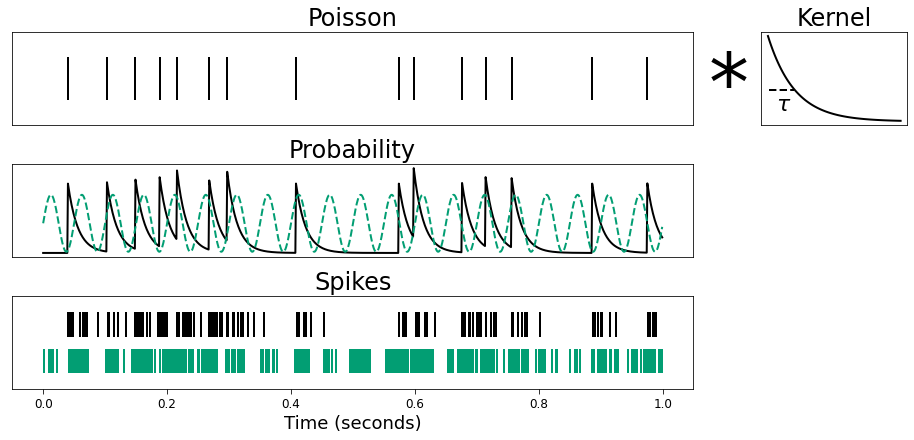

In [5]:
fig = plt.figure(constrained_layout=True, figsize=(14, 6))
gs = fig.add_gridspec(3, 20)

ax0 = fig.add_subplot(gs[0, :14])
ax1 = fig.add_subplot(gs[0, 14:15])
ax2 = fig.add_subplot(gs[0, 15:18])
ax3 = fig.add_subplot(gs[1, :14], sharex=ax0)
ax4 = fig.add_subplot(gs[2, :14], sharex=ax0)

ax0.eventplot(times[np.where(poisson)[0]], color='k')
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)
ax0.set_title('Poisson')

ax1.text(.2, 0.15, '*', fontdict={'fontsize': 80})
ax1.axis('off')

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.plot(kernel[:80], color='k')
ax2.axhline(y=np.max(kernel)/np.exp(1), xmin=0.05, xmax=.225, ls='--', color='k')
ax2.text(5, .008, r'$\tau$', size=22)
ax2.set_title('Kernel')

ax3.plot(times, probs_ap, color='k')
ax3.plot(times, probs_pe, color='C2', ls='--')
ax3.set_title('Probability')
ax3.set_yticks([])
ax3.get_xaxis().set_visible(False)

ax4.eventplot(times[np.where(spikes_ap)[0]], lineoffsets=2.5, color='k')
ax4.eventplot(times[np.where(spikes)[0]], color='C2')
ax4.set_title('Spikes')
ax4.set_yticks([])
ax4.set_xlabel('Time (seconds)')

plt.savefig('fig03_simulation.png', dpi=300, facecolor='white')